#### Status: Draft

Let's count the number of .fits files we have

In [1]:
!ls *.fits | wc -l

68



We'll start by importing the libraries and modules we'll need.  

We want astropy to load fits files and matplotlib to show the image.

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt

from astropy.stats import sigma_clipped_stats

We'll need to load the file first. We use `open()` function from fits submodule in astropy.  
The returned object has `.info()` method which shows the information about the HDU's contained in the fits file which are like tables or spreadsheet kind of data.

In [3]:
img = fits.open("./ceph_2451890.76992.fits")
img.info()

Filename: ./ceph_2451890.76992.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     143   (201, 201)   int16   


Let's checkout the content of the first(and the only in this case) HDU

In [84]:
ceph_fits = img[0]
data = ceph_fits.data
header = ceph_fits.header

In [85]:
header['DATE-OBS']

'29/12/2000'

These are raw event count for that particular exposure.  

Now, use `imshow()` function from pyplot to plot the image which is in 2-dim matrix shape.

In [87]:
mean, median, std = sigma_clipped_stats(data)

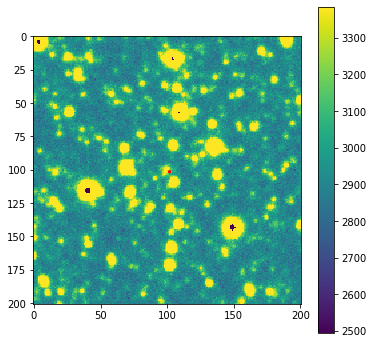

In [89]:
plt.figure(figsize=(6,6))

# set the scale of the image based on its statistics
# any pixel above vmax will show up with the same color as vmax. And vice-versa for vmin
plt.imshow(data, vmin = median - 5*std, vmax = median + 5*std, cmap='viridis')
plt.colorbar()
plt.scatter(101,101, marker="*", c='r', s=8)

Let's now examine the periodic behaviour of the central pixel where our cepheid lies. 

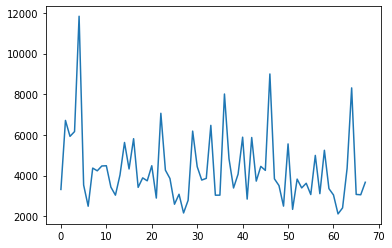

In [8]:
from pathlib import Path
p = Path('./')
curve = []
for file in p.iterdir():
    if file.suffix != '.fits': continue
    img = fits.open(file)
    curve.append(img[0].data[101,101])
    
curve

plt.plot(curve)

That looks somewhat periodic, but definitely not as much as we'd expect.

We haven't introduced the date into the picture yet. It could be that the `.iterfiles()` method we used, doesn't iterate in sorted order.  

So, let's read the juilan date from the file and use it along x-axis. 

Also, let's introduce an aperture size. A single pixel might suffer from statistical noise.

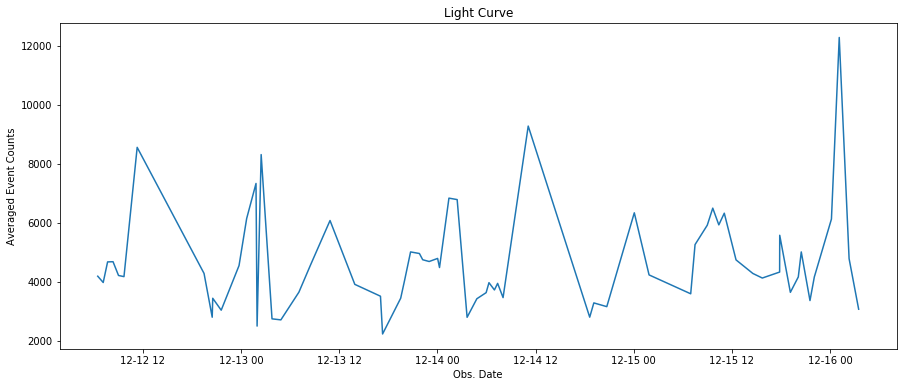

In [48]:
curve = []
a = 1 # square aperture of side 2a+1 is used
for file in p.iterdir():
    if file.suffix != '.fits': continue
    img = fits.open(file)
    mean_count = img[0].data[101-a:102+a,101-a:102+a].mean()
    curve.append([str(file)[5:18], mean_count])
    
# We'll need a few more libraries
import numpy as np
import pandas as pd
import julian

curve = np.array(curve, dtype="float")
df = pd.DataFrame(curve, columns=['date', 'mcount'])
df = df.sort_values('date')
df['dtime'] = df.date.map(julian.from_jd)

fig = plt.figure(0, [15, 6])
ax = fig.add_subplot()
ax.plot(df.dtime, df.mcount)
_ = ax.set(title="Light Curve",
           xlabel="Obs. Date", 
           ylabel="Averaged Event Counts")

Let's use a circular aperture instead of a square one let's write and test a function to generate the filter

In [69]:
def get_circular_aperture(img, x, y, r):
    """Circular filter of size img.shape centered at
    x,y and of radius r
    Inputs: img  -- array like
            x, y -- int (center)
            r    -- int (radius)
    Returns: filter -- array like of same shape as img"""
    
    filter = np.zeros(img.shape)
    len = filter.shape[0]
    for i in range(len):
        for j in range(len):
            if ((i-x)**2 + (j-y)**2 < r):
                filter[i][j] = 1
    return filter

filter = get_circular_aperture(data, 101, 101, 10)
print(filter[95:107, 95:107])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


That works like we expect. Let's use it to get a filter and convolve it with the image.

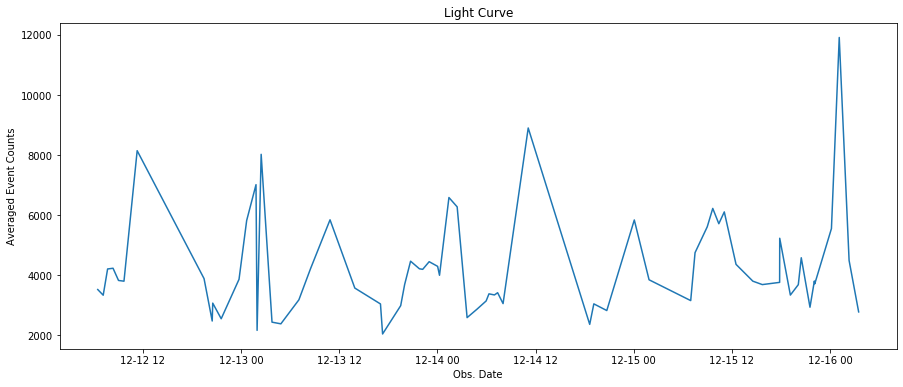

In [90]:
curve = []
a = 3 # circular aperture of radius 5
for file in p.iterdir():
    if file.suffix != '.fits': continue
    img = fits.open(file)
    arr = img[0].data
    filter = get_circular_aperture(arr, 101, 101, a)
    mean_count =  arr.ravel().dot(filter.ravel()) / filter.sum()
    curve.append([str(file)[5:18], mean_count])

curve = np.array(curve, dtype="float")
df = pd.DataFrame(curve, columns=['date', 'mcount'])
df = df.sort_values('date')
df['dtime'] = df.date.map(julian.from_jd)

fig = plt.figure(0, [15, 6])
ax = fig.add_subplot()
ax.plot(df.dtime, df.mcount)
_ = ax.set(title="Light Curve",
           xlabel="Obs. Date", 
           ylabel="Averaged Event Counts")

That didn't change it very much.